[View in Colaboratory](https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/DL_003_filter_nodules_by_diameter.ipynb)

# Deep Learning applied to Nodule Segmentation in Lung CT-scans

## Prepare Virtual Machine

In [1]:
## Connect to google drive for storage 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install pylidc

gpg: keybox '/tmp/tmpyxngu7vq/pubring.gpg' created
gpg: /tmp/tmpyxngu7vq/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [1]:
!google-drive-ocamlfuse -cc #refresh google drive

Clearing cache...done


In [0]:
PATH="drive/LIDC-dataset/data/LIDC-IDRI"

In [0]:
!rm .pylidcrc
!touch .pylidcrc
!echo "[dicom]" >> .pylidcrc
!echo "path = drive/LIDC-dataset/data/LIDC-IDRI" >> .pylidcrc
!echo "warn = True" >> .pylidcrc

# Load Dicom Data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import pylidc as pl
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [6]:
files = !ls drive/LIDC-dataset/data/LIDC-IDRI
files

['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011',
 'LIDC-IDRI-0012']

In [0]:
qu = pl.query(pl.Scan)

In [8]:
scans=qu.all() #all scans in the original LIDC dataset
scans[0:5]

[Scan(id=1,patient_id=LIDC-IDRI-0078),
 Scan(id=2,patient_id=LIDC-IDRI-0069),
 Scan(id=3,patient_id=LIDC-IDRI-0079),
 Scan(id=4,patient_id=LIDC-IDRI-0101),
 Scan(id=5,patient_id=LIDC-IDRI-0110)]

In [9]:
ind = [i for i,s in enumerate(scans) if s.patient_id =="LIDC-IDRI-0001"]
ind

[11]

In [10]:
ind = [i for i,s in enumerate(scans) if s.patient_id in files]
ind

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [11]:
mini_scans=[scans[i] for i in ind];  mini_scans

[Scan(id=12,patient_id=LIDC-IDRI-0001),
 Scan(id=13,patient_id=LIDC-IDRI-0002),
 Scan(id=14,patient_id=LIDC-IDRI-0003),
 Scan(id=15,patient_id=LIDC-IDRI-0004),
 Scan(id=16,patient_id=LIDC-IDRI-0005),
 Scan(id=17,patient_id=LIDC-IDRI-0006),
 Scan(id=18,patient_id=LIDC-IDRI-0007),
 Scan(id=19,patient_id=LIDC-IDRI-0008),
 Scan(id=20,patient_id=LIDC-IDRI-0009),
 Scan(id=21,patient_id=LIDC-IDRI-0010),
 Scan(id=22,patient_id=LIDC-IDRI-0011),
 Scan(id=23,patient_id=LIDC-IDRI-0012)]

In [12]:
scan=mini_scans[0]
scan.annotations

[Annotation(id=84,scan_id=12),
 Annotation(id=85,scan_id=12),
 Annotation(id=86,scan_id=12),
 Annotation(id=87,scan_id=12)]

In [25]:
scan.visualize()

Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#check all scans are ok to read
scans_ok=[]
scans_error=[]

for q in mini_scans:
  try:
    q.get_path_to_dicom_files()
    scans_ok.append(q)
  except:
    scans_error.append(q)

print(len(scans_ok),len(scans_error),len(mini_scans))

12 0 12


# Split data to train, validate, test

In [0]:
import random
import numpy as np

In [28]:
#shuffle data, then split to train, valid, test
random.seed(313)
random.shuffle(scans_ok)
len(scans_ok)

12

In [29]:
L=len(scans_ok)
j=np.int(.6*L)
jj=np.int(.2*L)
j,jj

(7, 2)

In [30]:
scans_train=scans_ok[0:j]
scans_valid=scans_ok[j:j+jj]
scans_test=scans_ok[j+jj:]
print(len(scans_train),len(scans_valid),len(scans_test))

7 2 3


In [31]:
scans_train,scans_valid,scans_test

([Scan(id=15,patient_id=LIDC-IDRI-0004),
  Scan(id=16,patient_id=LIDC-IDRI-0005),
  Scan(id=17,patient_id=LIDC-IDRI-0006),
  Scan(id=22,patient_id=LIDC-IDRI-0011),
  Scan(id=20,patient_id=LIDC-IDRI-0009),
  Scan(id=23,patient_id=LIDC-IDRI-0012),
  Scan(id=13,patient_id=LIDC-IDRI-0002)],
 [Scan(id=12,patient_id=LIDC-IDRI-0001),
  Scan(id=19,patient_id=LIDC-IDRI-0008)],
 [Scan(id=18,patient_id=LIDC-IDRI-0007),
  Scan(id=14,patient_id=LIDC-IDRI-0003),
  Scan(id=21,patient_id=LIDC-IDRI-0010)])

# Filter annotation according to nodule diameter



In [75]:
scans0=scans_train
filename = "drive/df2_ann_filter_train.csv"

#consider only annonations of diameter < 30mm  and greater than 6mm 

if False:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_train=df2
    print(f"df1.shape[0],df3.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_train=pd.read_csv(filename,index_col=0)
print(df_train.shape[0])
df_train.head()

63


,ann_id,scan_id,nodule_diameter
0,103,15,6.262191
1,105,15,7.025444
2,106,15,8.465747
3,107,16,6.264748
4,108,16,8.658309


In [76]:
#Repeat for validation set
scans0=scans_valid
filename = "drive/df2_ann_filter_valid.csv"
#consider only annonations of diameter < 30mm  and greater than 6mm 

if False:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_valid=df2
    print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_valid=pd.read_csv(filename,index_col=0)
print(df_valid.shape[0])
df_valid.head()

7


,ann_id,scan_id,nodule_diameter
0,129,19,8.156489
1,130,19,6.987712
2,131,19,11.718750
3,132,19,8.907621
4,133,19,8.156489


In [77]:
#Repeat for validation set
scans0=scans_test
filename = "drive/df2_ann_filter_test.csv"
#consider only annonations of diameter < 30mm  and greater than 6mm 

if False:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_test=df2
    print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_test=pd.read_csv(filename,index_col=0)
print(df_test.shape[0])
df_test.head()

16


,ann_id,scan_id,nodule_diameter
0,125,18,20.684691
1,91,14,13.353712
2,92,14,14.674187
3,94,14,14.326133
4,95,14,11.943923


# Plot distribution of nodule diameter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a3e4dbcf8>]],
      dtype=object)

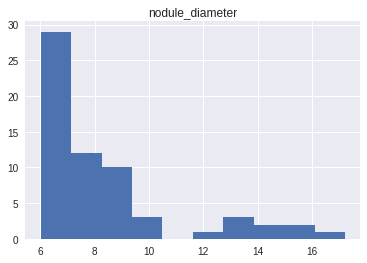

In [78]:
df_train.hist(column='nodule_diameter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a4238cb38>]],
      dtype=object)

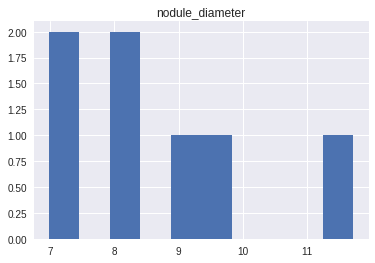

In [79]:
#look at  the distribution of nodules after filtering
df_valid.hist(column='nodule_diameter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a3e4dd9e8>]],
      dtype=object)

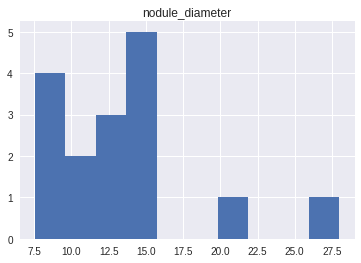

In [80]:
#look at  the distribution of nodules after filtering
df_test.hist(column='nodule_diameter')

The distribution of the nodule diameter is higly unbalanced. The number of small nodules is greater than the number of large nodules. Hence,  if uniform sampling is used, the network will be biased towards small nodules.

In [0]:
root_dir="drive/"
interm_dir=root_dir+"interm5/"#save the scan ids that will be considered
if False:
    scan_id_train=list(set(df_train["scan_id"]))
    scan_id_valid=list(set(df_valid["scan_id"]))
    scan_id_test=list(set(df_test["scan_id"]))
    filename=interm_dir+"scan_id_split"
    with open(filename, 'wb') as f:
        pickle.dump([scan_id_train,scan_id_valid,scan_id_test], f)
else:
    filename=interm_dir+"scan_id_split"
    with open(filename, 'rb') as f:
        scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)